## Galaxy_viewer

Produces an image of a single galaxy or several

In [2]:
import numpy as np
import matplotlib
import pandas as pd
import gc
# allow for matplotlib to create inline plots in our notebook
%matplotlib inline
import matplotlib.pyplot as plt      # imports matplotlib.pyplot as plt

import lsst.daf.butler as dafButler     # gen3 butler
from astropy.wcs import WCS          # imports astropy's World Coordinate System function WCS

import lsst.sphgeom
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.geom import SpherePoint, Angle
afwDisplay.setDefaultBackend('matplotlib') 

butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')
filter_id = 'r'

In [22]:
a = pd.read_csv('input.txt', delim_whitespace = True)
ra1 = a['RA']
dec1 = a['DEC']

In [3]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [4]:
# Find the tract and patch for the coadd associated with a particular point
def find_tract_patch(ra, dec):
    my_spherePoint = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
    skymap = butler.get('skyMap')
    my_tract = skymap.findTract(my_spherePoint)
    my_patch = my_tract.findPatch(my_spherePoint)
    my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
    tract1 = str(my_tract)
    patch1_ok = str(my_patch_id)
    tract1_ok = tract1[13:17]
    tract = int(tract1_ok)
    patch = int(patch1_ok)
    dataId = {'band': filter_id, 'tract': int(tract1_ok), 'patch':int(patch1_ok)}
    return dataId


In [5]:
#Shows the full image view
def full_image(ra, dec, dataId):
    datasetType = 'deepCoadd'
    coadd = butler.get(datasetType, **dataId)
    radec = SpherePoint(ra, dec, lsst.geom.degrees)
    xy = coadd.getWcs().skyToPixel(radec)
#    fig, ax = plt.subplots(xdim, ydim, figsize=(10, 10))
#    plt.sca(ax[0])

    fig = plt.figure(figsize=(20,20))
    display = afwDisplay.Display(frame=1, backend='matplotlib')
    display.scale("asinh", "zscale")
 #   display.mtv(image.getMaskedImage().getImage())
    
 #   coadd.image.writeFits('output.fits')
    display.mtv(coadd.image)
    display.dot('o', xy.getX(), xy.getY(), ctype='green', size = 20)
  #  display.dot('o', xy.getX(), xy.getY(), ctype='green', size =40)
 #   plt.show()
  #  display.mtv(image.getMaskedImage().getImage())
    return


In [6]:
def cutout_coadd(butler, ra, dec, dataid, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

  #  coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=dataid)

    return cutout_image

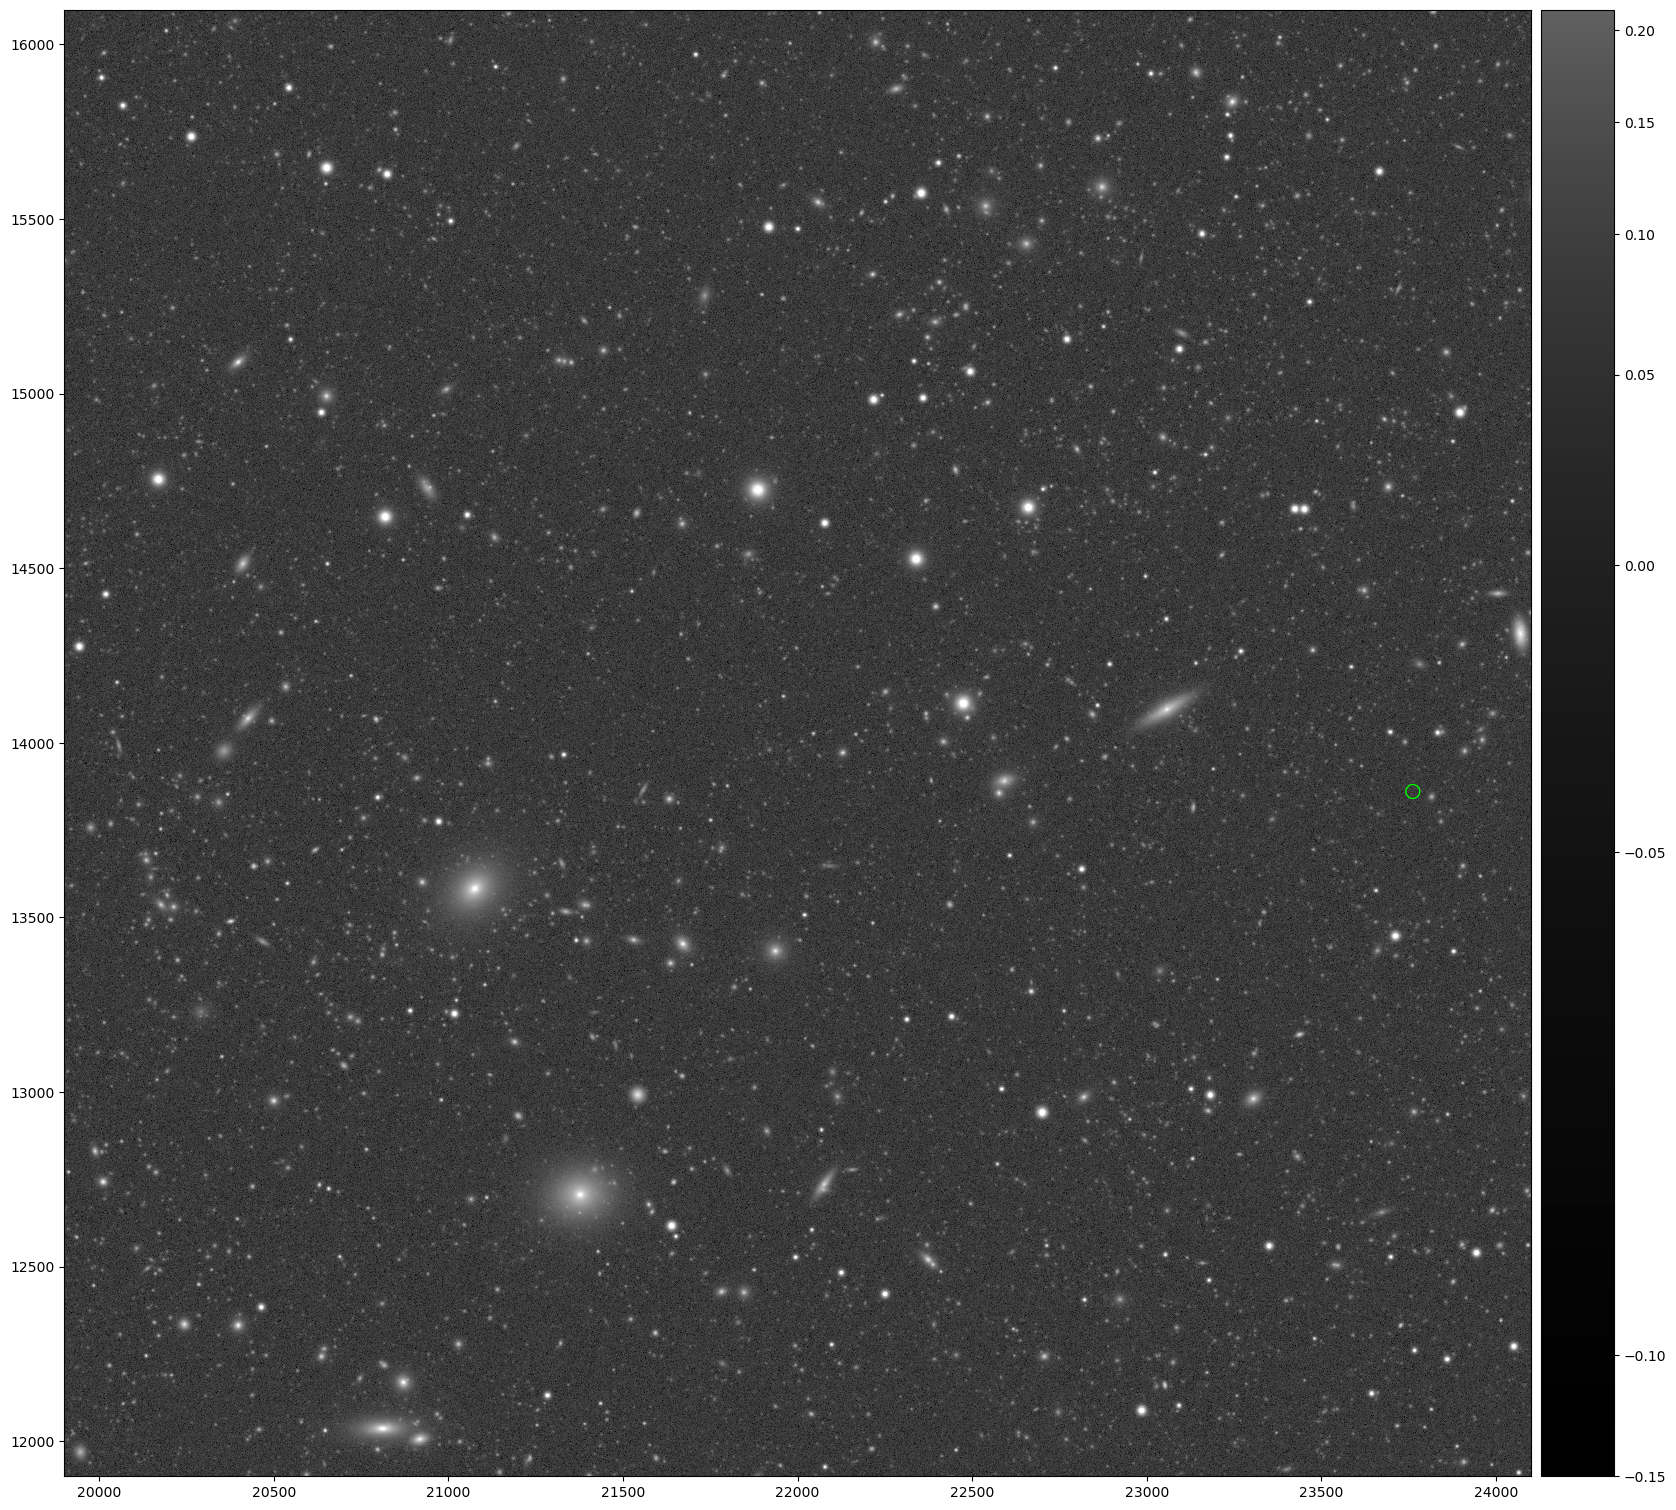

In [16]:
#ra = 57.6491576 edge on galaxy
#dec = -39.26560194
#ra = 59.6491576 
#dec = -37.26560194
#dataid = find_tract_patch(ra,dec)
#full_image(ra,dec,dataid)



i=3
#for i in range(1,2):
dataid = find_tract_patch(ra[i],dec[i])
full_image(ra[i],dec[i],dataid)
#    input()


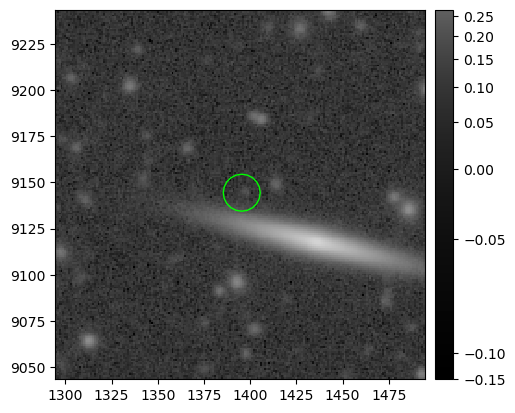

In [32]:
ra = ra1[10]
dec = dec1[10]

dataid = find_tract_patch(ra,dec)
cutout_image = cutout_coadd(butler, ra, dec, dataid, band='i', datasetType='deepCoadd',
                            cutoutSideLength=200)
fig, ax = plt.subplots()
radec = SpherePoint(ra, dec, lsst.geom.degrees)
xy = cutout_image.getWcs().skyToPixel(radec)
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
display.dot('o', xy.getX(), xy.getY(), ctype='green', size = 10)
plt.show()
remove_figure(fig)

60.23227697 -36.70295117
{'band': 'r', 'tract': 3830, 'patch': 17}
dict_keys(['band', 'skymap', 'tract', 'patch'])


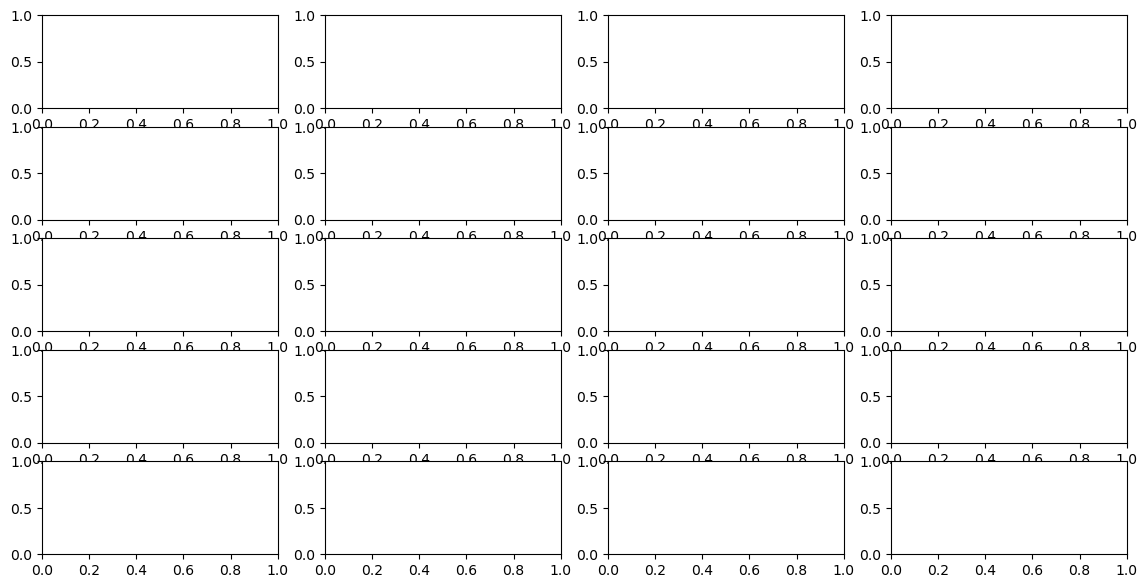

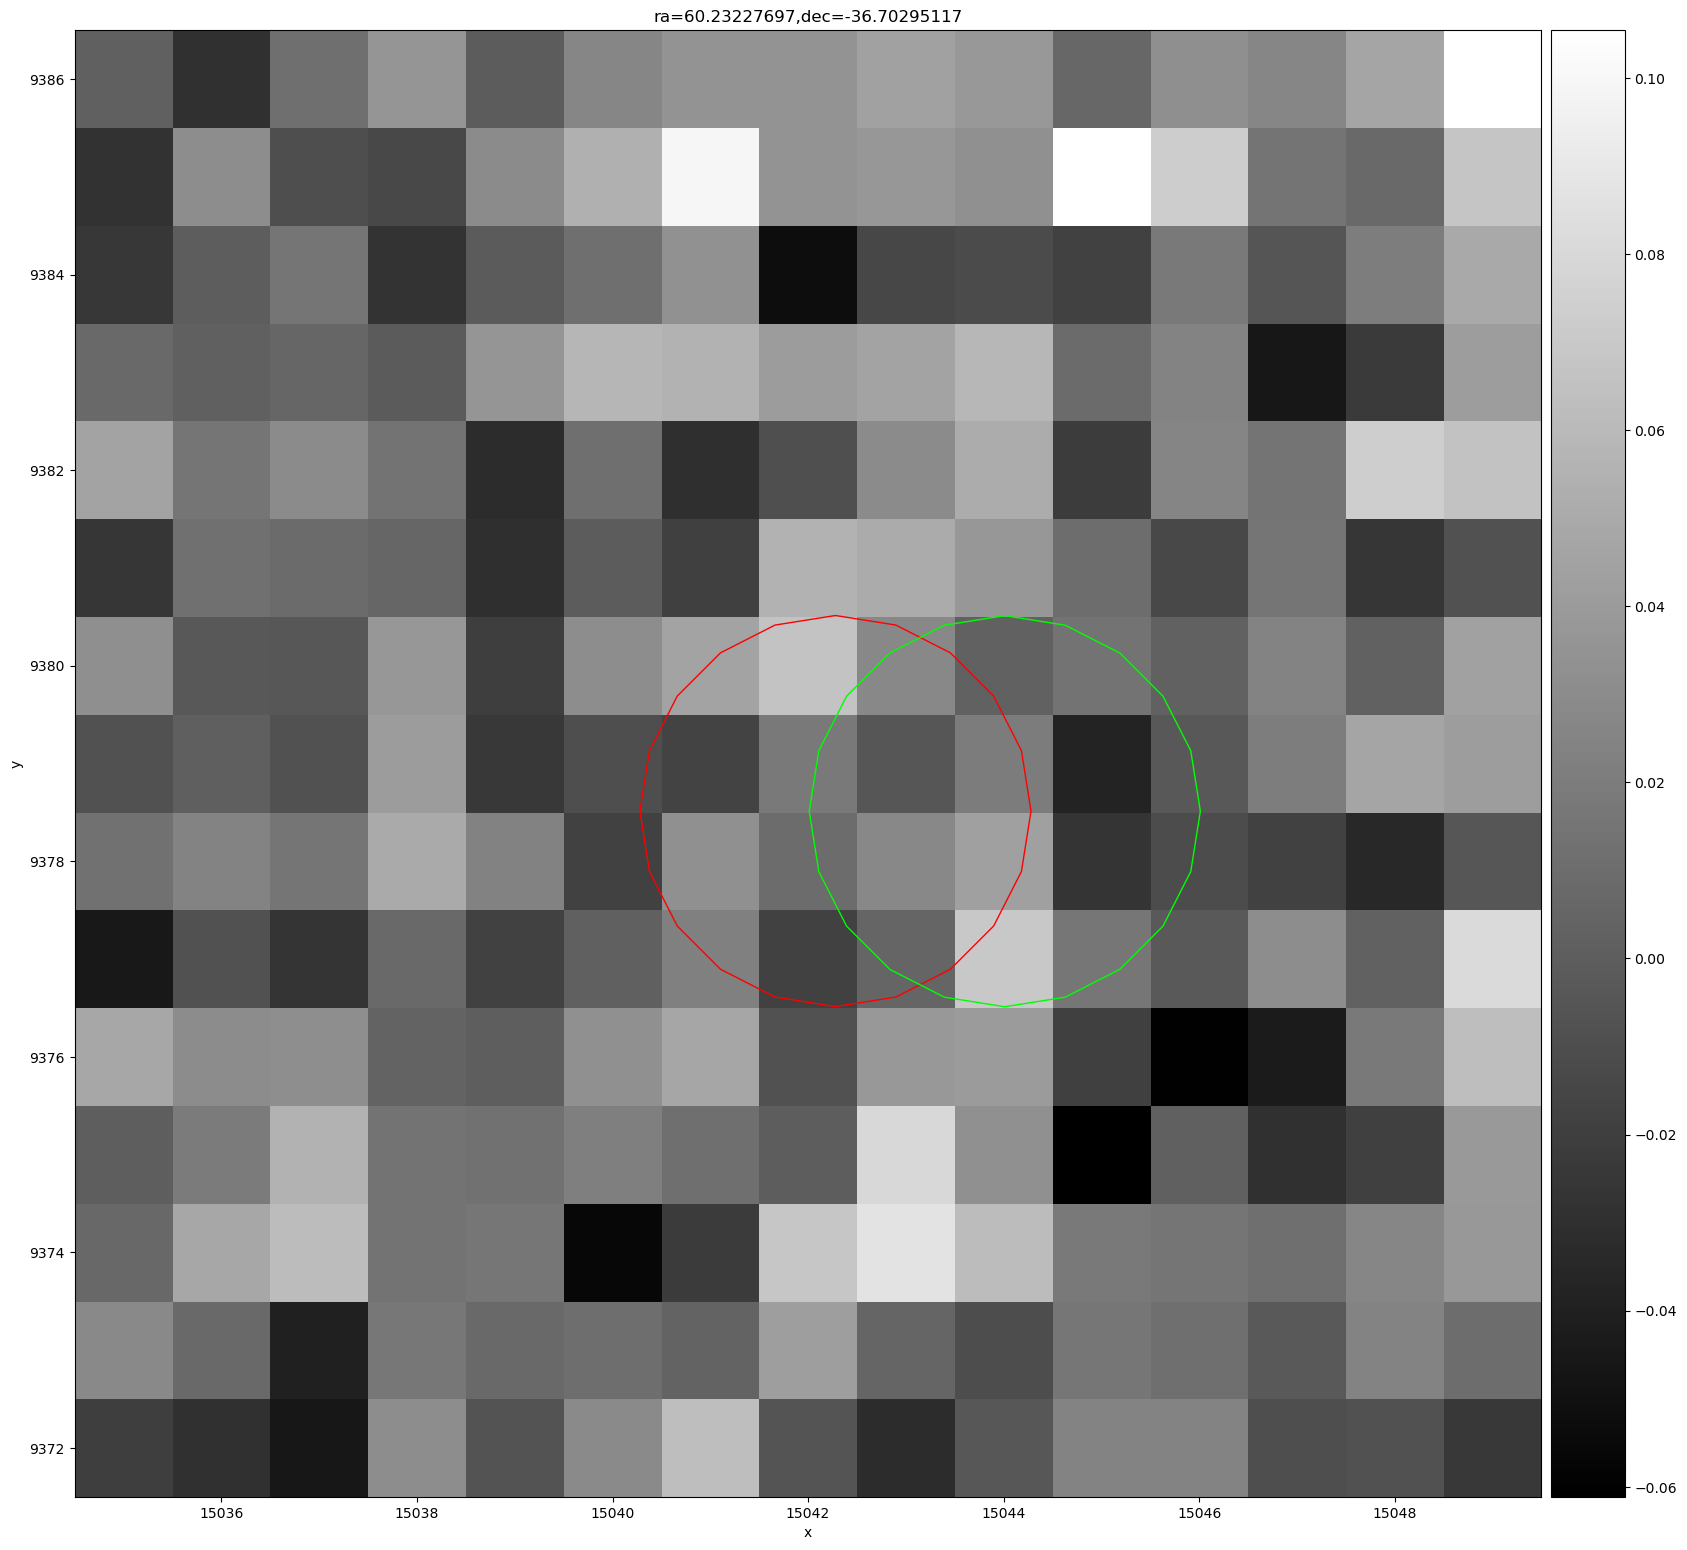

59.74513893 -37.09317761
{'band': 'r', 'tract': 3830, 'patch': 5}
dict_keys(['band', 'skymap', 'tract', 'patch'])


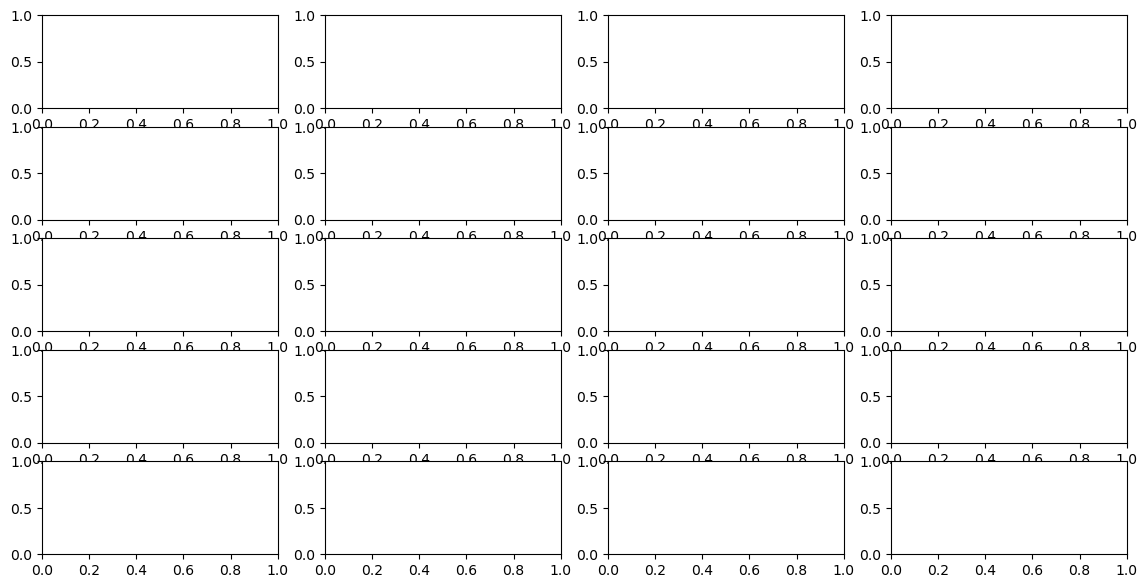

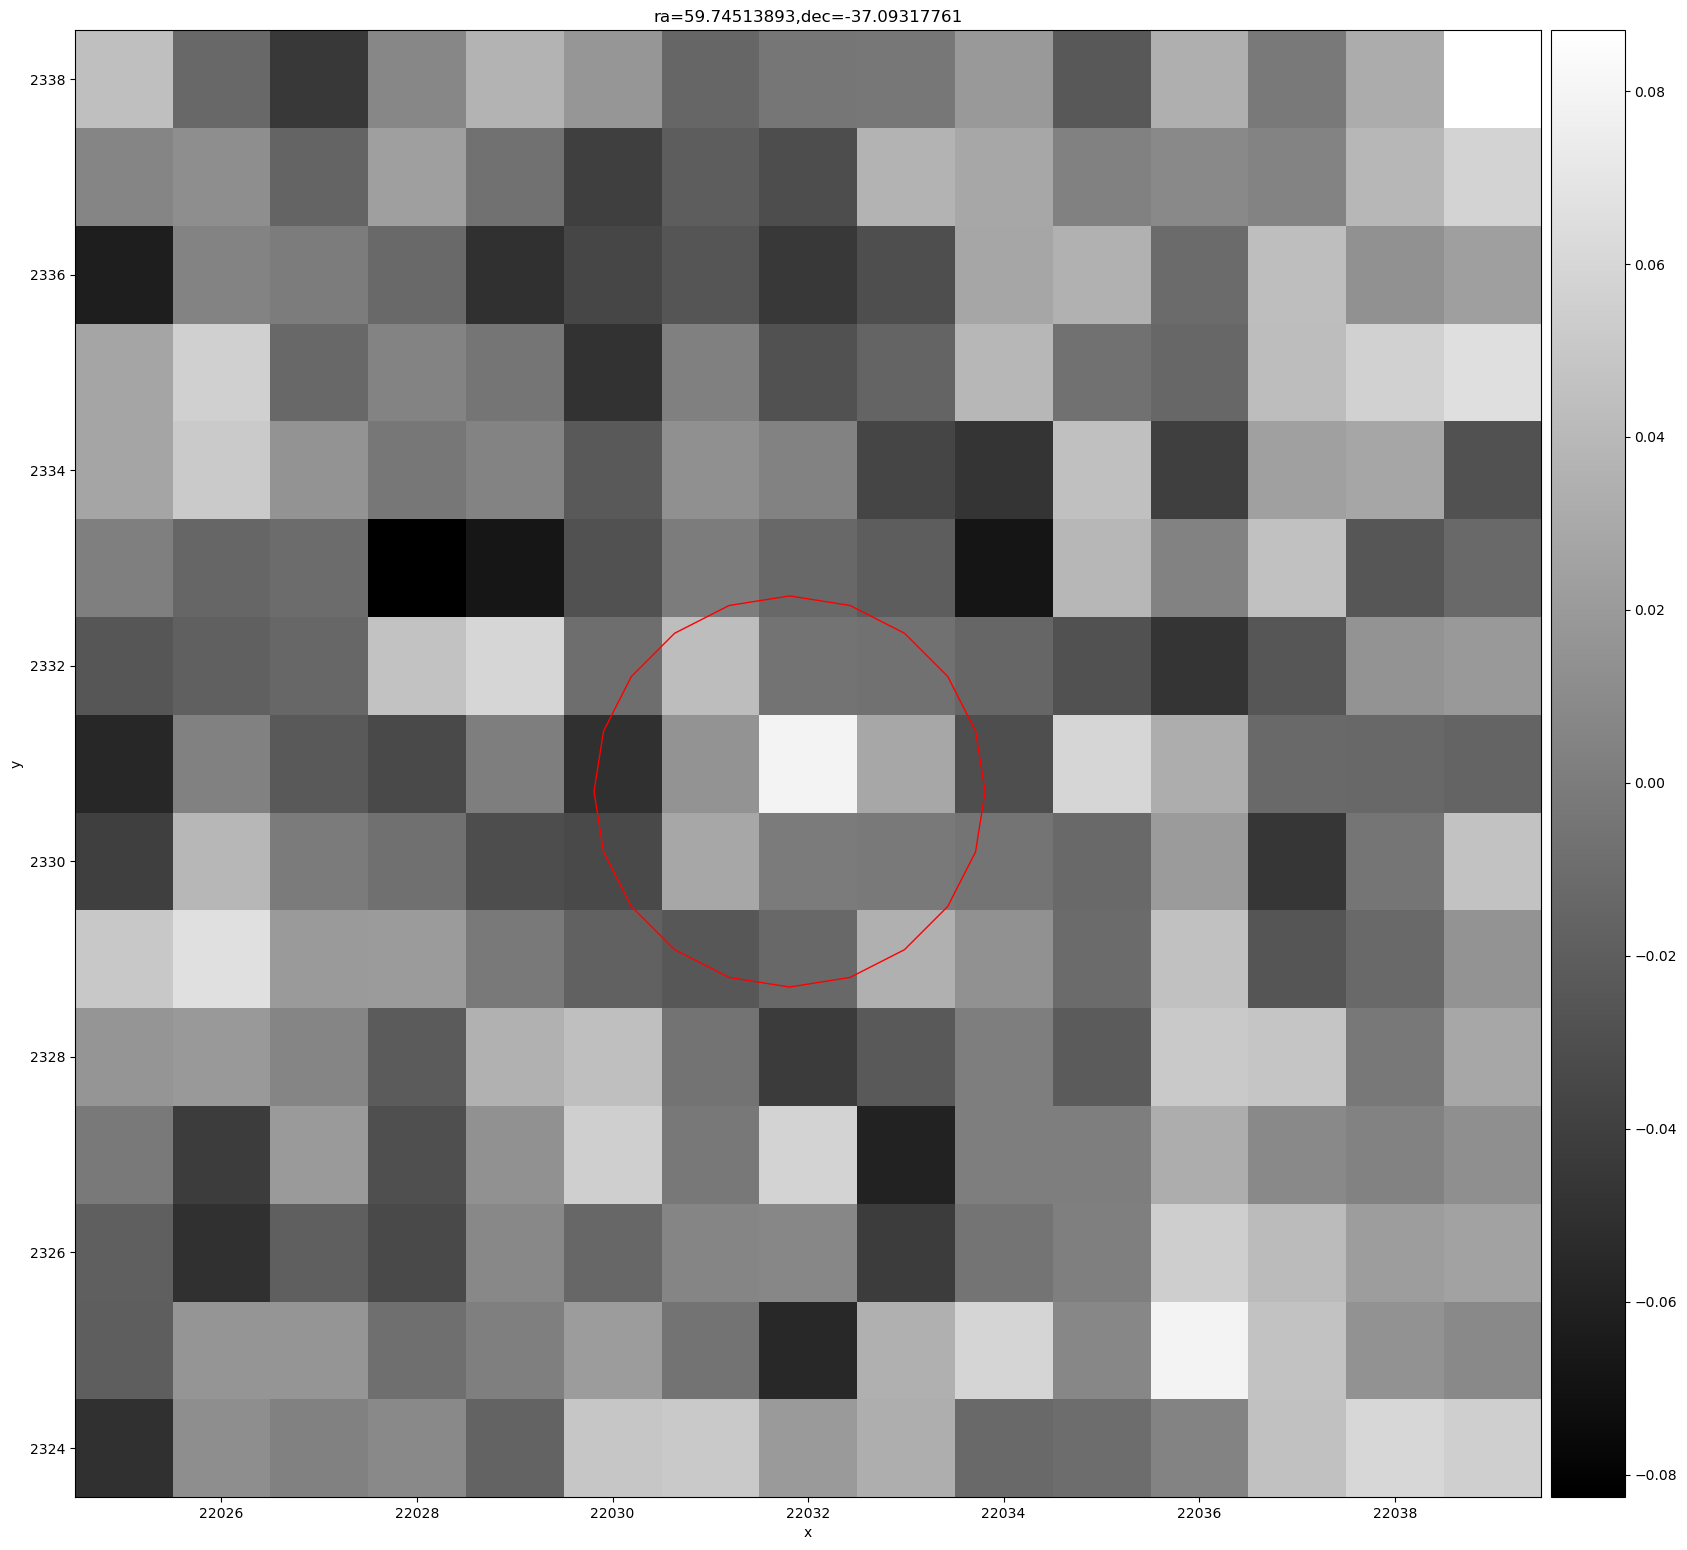

In [16]:
data = pd.read_csv('input.txt', delim_whitespace=True)

filter_id='r'
coadd_type = 'deepCoadd'

ra1 = data['RA']
dec1 = data['DEC']

for i in range(0, 2):
    ra=ra1[i]
    dec=dec1[i]
    print(ra,dec)
   
    my_spherePoint = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
    skymap = butler.get('skyMap')
    my_tract = skymap.findTract(my_spherePoint)
    my_patch = my_tract.findPatch(my_spherePoint)
    my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
    tract1 = str(my_tract)
    patch1_ok = str(my_patch_id)
    tract1_ok = tract1[13:17]
    tract = int(tract1_ok)
    patch = int(patch1_ok)
    dataId = {'band': filter_id, 'tract': int(tract1_ok), 'patch':int(patch1_ok)}
    print(dataId)
    
    print(butler.registry.getDatasetType(coadd_type).dimensions.required.names)
    coadd_id = {'tract': tract, 'patch': patch, 'band': filter_id}
    image = butler.get(coadd_type, dataId=coadd_id)
    radec = SpherePoint(ra, dec, lsst.geom.degrees)
    xy = image.getWcs().skyToPixel(radec)
    
    fig = plt.figure(figsize=(20,20))
    display = afwDisplay.Display(frame=1, backend='matplotlib')
    display.scale("linear", "zscale")
    display.mtv(image.getMaskedImage().getImage())
    display.dot('o', xy.getX(), xy.getY(), ctype='green', size =40)
    
    fig, ax = plt.subplots(5, 4, figsize=(14, 7))
    # Define the center and size of our cutout
    radec = SpherePoint(ra, dec, lsst.geom.degrees)
    cutout_size = 15
    cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

#    ra2 = ra-0.00012
#    dec2 = dec-0.00000
#    radec2 = SpherePoint(ra2, dec2, lsst.geom.degrees)
#    xy2 = image.getWcs().skyToPixel(radec2)
#    print(radec2)

    # Cutout and optionally save the postage stamp to file
    postage_stamp = image.getCutout(radec, cutout_extent)
    # postage_stamp.writeFits(<output_filename>)

    # Convert RA,DEC on the sky to X,Y in the image
    xy = postage_stamp.getWcs().skyToPixel(radec)

    # Display image
    display = afwDisplay.Display(frame=1, backend='matplotlib')
    display.mtv(postage_stamp.getImage())
    display.scale("linear", "zscale")
    display.dot('o', xy.getX(), xy.getY(), ctype='red', size=2)
    display.dot('o', xy2.getX(), xy2.getY(), ctype='green', size=2)
    display.show_colorbar()

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('ra='+str(ra)+','+'dec='+str(dec))#+','+'mag_r='+str(mag_r))
    plt.show()

In [ ]:
 

    fig = plt.figure(figsize=(20,20))
    display = afwDisplay.Display(frame=1, backend='matplotlib')
    display.scale("linear", "zscale")
    display.mtv(image.getMaskedImage().getImage())
    display.dot('o', xy.getX(), xy.getY(), ctype='green', size =40)


    fig, ax = plt.subplots(5, 4, figsize=(14, 7))
    # Define the center and size of our cutout
    radec = SpherePoint(ra, dec, lsst.geom.degrees)
    cutout_size = 15
    cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

    ra2 = ra-0.00012
    dec2 = dec-0.00000
    radec2 = SpherePoint(ra2, dec2, lsst.geom.degrees)
    xy2 = image.getWcs().skyToPixel(radec2)
    print(radec2)

    # Cutout and optionally save the postage stamp to file
    postage_stamp = image.getCutout(radec, cutout_extent)
    # postage_stamp.writeFits(<output_filename>)

    # Convert RA,DEC on the sky to X,Y in the image
    xy = postage_stamp.getWcs().skyToPixel(radec)

    # Display image
    display = afwDisplay.Display(frame=1, backend='matplotlib')
    display.mtv(postage_stamp.getImage())
    display.scale("linear", "zscale")
    display.dot('o', xy.getX(), xy.getY(), ctype='red', size=2)
    display.dot('o', xy2.getX(), xy2.getY(), ctype='green', size=2)
    display.show_colorbar()

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('ra='+str(ra)+','+'dec='+str(dec))#+','+'mag_r='+str(mag_r))
    plt.show()


In [20]:
#my_spherePoint = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees, -32.269167*lsst.geom.degrees)
my_spherePoint = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
print(my_spherePoint)

#dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}

skymap = butler.get('skyMap')
my_tract = skymap.findTract(my_spherePoint)
my_patch = my_tract.findPatch(my_spherePoint)
my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
tract1 = str(my_tract)
patch1_ok = str(my_patch_id)
tract1_ok = tract1[13:17]
tract = int(tract1_ok)
patch = int(patch1_ok)

#dataId = """{'band': """+"""'"""+filter_id+"""','tract': """+tract1_ok+""", 'patch':"""+tract2+"""}"""

dataId = {'band': filter_id, 'tract': int(tract1_ok), 'patch':int(patch1_ok)}

print('my_tract = ', my_tract)
print('my_patch = ', my_patch)
print('my_patch_id = ',my_patch_id)
print(dataId)

(62.0291800000, -36.7025080000)
my_tract =  TractInfo(id=3831)
my_patch =  PatchInfo(index=Index2D(x=3, y=2))
my_patch_id =  17
{'band': 'r', 'tract': 3831, 'patch': 17}


In [24]:
coadd_type = 'deepCoadd'

if genvers == 'gen2':
    butler.getKeys(coadd_type)
elif genvers == 'gen3':
    print(butler.registry.getDatasetType(coadd_type).dimensions.required.names)

# Retrieve the image using butler
if genvers == 'gen2':
    coadd_id = {'tract': tract, 'patch': patch, 'filter': filter_id}
    image = butler.get(coadd_type, dataId=coadd_id)
elif genvers == 'gen3':
    coadd_id = {'tract': tract, 'patch': patch, 'band': filter_id}
    image = butler.get(coadd_type, dataId=coadd_id)

print(tract)
print(patch)
print(filter_id)
print(dataId)

dict_keys(['band', 'skymap', 'tract', 'patch'])
3831
17
r
{'band': 'r', 'tract': 3831, 'patch': 17}


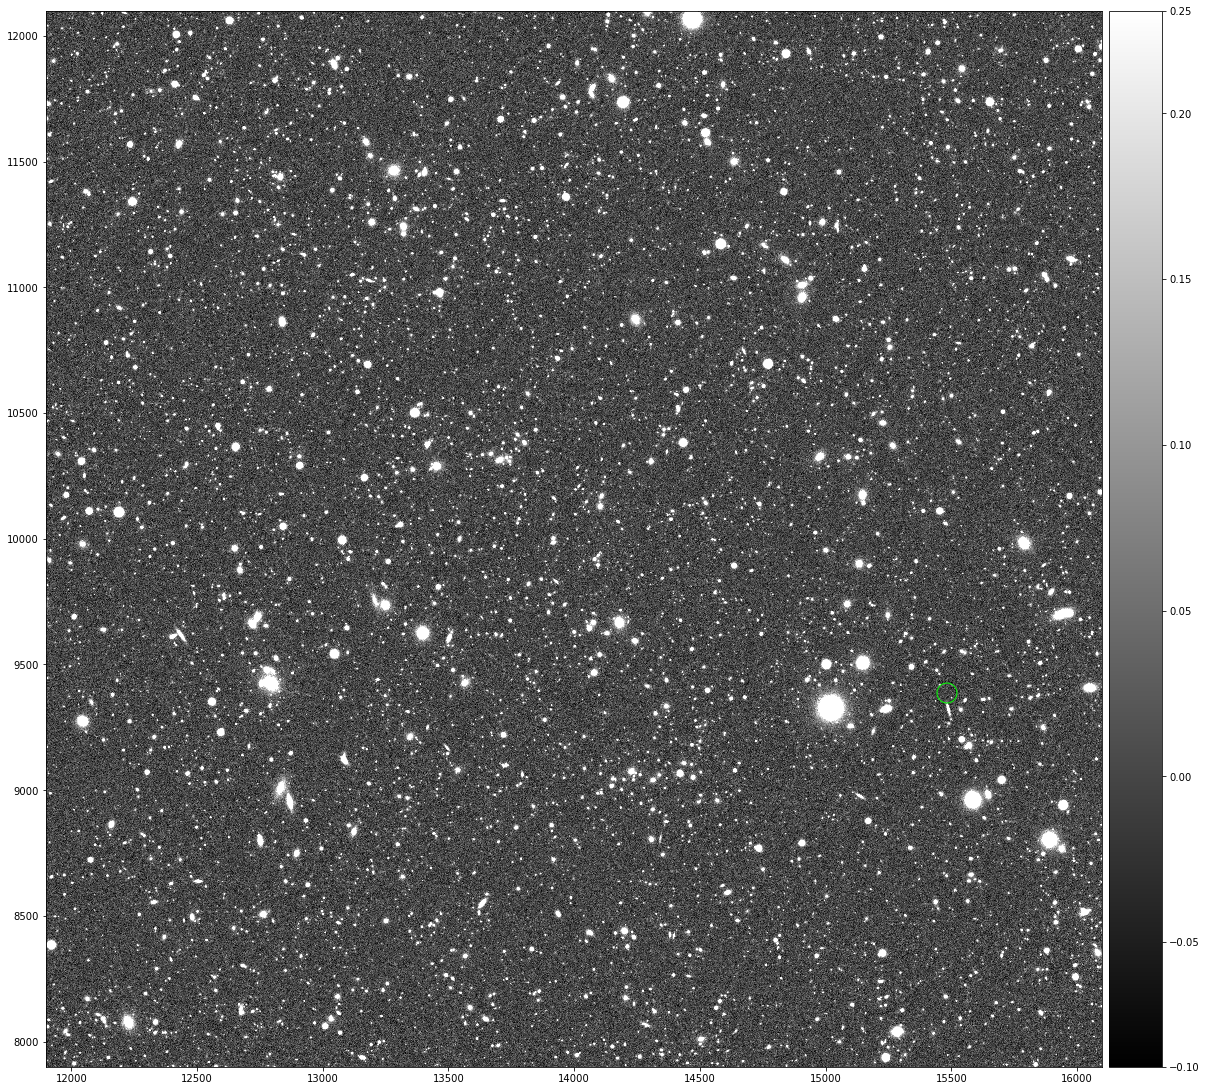

In [25]:
# Let's take a look at the full image first
radec = SpherePoint(ra, dec, lsst.geom.degrees)
xy = image.getWcs().skyToPixel(radec)

fig = plt.figure(figsize=(20,20))
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(image.getMaskedImage().getImage())
display.dot('o', xy.getX(), xy.getY(), ctype='green', size =40)

(62.0290600000, -36.7025080000)


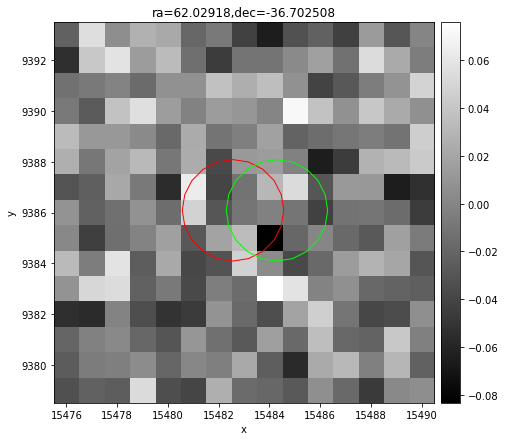

In [26]:
fig, ax = plt.subplots(5, 4, figsize=(14, 7))
# Define the center and size of our cutout
radec = SpherePoint(ra, dec, lsst.geom.degrees)
cutout_size = 15
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

ra2 = ra-0.00012
dec2 = dec-0.00000
radec2 = SpherePoint(ra2, dec2, lsst.geom.degrees)
xy2 = image.getWcs().skyToPixel(radec2)
print(radec2)

# Cutout and optionally save the postage stamp to file
postage_stamp = image.getCutout(radec, cutout_extent)
# postage_stamp.writeFits(<output_filename>)

# Convert RA,DEC on the sky to X,Y in the image
xy = postage_stamp.getWcs().skyToPixel(radec)

# Display image
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.mtv(postage_stamp.getImage())
display.scale("linear", "zscale")
display.dot('o', xy.getX(), xy.getY(), ctype='red', size=2)
display.dot('o', xy2.getX(), xy2.getY(), ctype='green', size=2)
display.show_colorbar()

plt.xlabel('x')
plt.ylabel('y')
plt.title('ra='+str(ra)+','+'dec='+str(dec))#+','+'mag_r='+str(mag_r))
plt.show()
